In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [ ]:
import zipfile
import os

with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

In [ ]:
!ls data/

data


In [ ]:
import shutil

shutil.move("data/data/train", "data/")
shutil.move("data/data/test", "data/")
shutil.move("data/data/GT-final_test.csv", "data/")

shutil.rmtree("data/data")

In [ ]:
!ls data/

GT-final_test.csv  test  train


In [ ]:
!pip install tensorflow==2.15.0 tensorflow-addons==0.23.0 --upgrade --force-reinstall
!pip install onnx-tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 k

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 81.0 MB/s eta 0:00:00


In [ ]:
!pip uninstall -y tensorflow-probability
!pip install tensorflow-probability==0.22.0

Found existing installation: tensorflow-probability 0.25.0
Uninstalling tensorflow-probability-0.25.0:
  Successfully uninstalled tensorflow-probability-0.25.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 57.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.14.0
    Uninstalling typing_extensions-4.14.0:
      Successfully uninstalled typing_extensions-4.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
onnx 1.18.0 requires typing_extensions>=4.7.1, but you have typing-extensions 4.5.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.15.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.15.0 which is incompatible.
google-genai 1.21.1 requires typing-extensions<5.0.0,>=4.11.0

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import transforms
import pandas as pd
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split
from PIL import Image
from onnx_tf.backend import prepare
import onnx
import tensorflow as tf
import numpy as np
import glob
import random
from tqdm import tqdm
import albumentations as A
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
source_dir = "data/train"
output_dir = "synthetic_dataset"
used_classes = [2, 13, 14, 15, 17, 27]
class_names = [str(c).zfill(5) for c in used_classes]
n_per_class = 500

augment = A.Compose([
    A.GaussianBlur(p=0.2),
    A.MotionBlur(p=0.2),
    A.ISONoise(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.Perspective(p=0.3),
    A.Rotate(limit=20),
    A.Resize(40, 40)
])

def generate_random_background(size=(240, 240)):
    mode = random.choice(["color", "noise", "gradient"])

    if mode == "color":
        color = tuple(np.random.randint(100, 255, size=3))
        return Image.new("RGB", size, color)

    elif mode == "noise":
        noise = np.random.randint(0, 256, (size[1], size[0], 3), dtype=np.uint8)
        return Image.fromarray(noise, mode="RGB")

    elif mode == "gradient":
        base = np.tile(np.linspace(0, 255, size[0]), (size[1], 1)).astype(np.uint8)
        gradient = np.stack([base] * 3, axis=2)
        return Image.fromarray(gradient, mode="RGB")

sign_paths = {}
for class_id in class_names:
    pattern = os.path.join(source_dir, class_id, "*")
    files = [f for f in glob.glob(pattern) if f.lower().endswith(('.ppm', '.jpg', '.jpeg', '.png'))]
    if files:
        sign_paths[class_id] = files  # wszystkie obrazki tej klasy

for class_id, samples in tqdm(sign_paths.items(), desc="Generowanie danych"):
    class_out_dir = os.path.join(output_dir, class_id)
    os.makedirs(class_out_dir, exist_ok=True)

    for i in range(n_per_class):
        try:
            sign_path_sample = random.choice(samples)
            sign = Image.open(sign_path_sample).convert("RGBA")
        except:
            print(f"Błąd przy otwieraniu {sign_path_sample}")
            continue

        bg = generate_random_background((240, 240))

        rotated = sign.rotate(random.uniform(-20, 20), expand=True)
        resized = rotated.resize((random.randint(80, 150), random.randint(80, 150)))

        x = random.randint(0, bg.width - resized.width)
        y = random.randint(0, bg.height - resized.height)
        bg_copy = bg.copy()
        bg_copy.paste(resized, (x, y), resized)

        aug_img = augment(image=np.array(bg_copy))["image"]

        out_path = os.path.join(class_out_dir, f"{class_id}_{i:04d}.jpg")
        Image.fromarray(aug_img).save(out_path)

Generowanie danych: 100%|██████████| 6/6 [00:14<00:00,  2.49s/it]


In [ ]:
USED_CLASSES = [2, 13, 14, 15, 17, 27]
class_names = [str(c).zfill(5) for c in USED_CLASSES]
class_to_idx = {name: i for i, name in enumerate(class_names)}

classes_map = [
    "50 speed limit",
    "give way",
    "STOP",
    "no vehicles",
    "no entry",
    "pedestrian crossing"
]

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), shear=5),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class MediumCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, len(USED_CLASSES))
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = MediumCNN().to(device)

In [ ]:
import os
print(sorted(os.listdir("data/train")))


['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']


In [ ]:
real_dataset = datasets.ImageFolder("data/train", transform=transform_train)
synthetic_dataset = datasets.ImageFolder("synthetic_dataset", transform=transform_train)

combined_samples = []
for dataset in [real_dataset, synthetic_dataset]:
    for path, _ in dataset.samples:
        class_folder = os.path.basename(os.path.dirname(path))
        if class_folder in class_names:
            label = class_to_idx[class_folder]
            combined_samples.append((path, label))

class FilteredImageDataset(Dataset):
    def __init__(self, samples, transform):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

full_dataset = FilteredImageDataset(combined_samples, transform=transform_train)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
labels_list = [label for _, label in combined_samples]
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels_list), y=labels_list)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 20
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    model.eval()
    val_loss = 0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {total_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_acc:.2f}%")

Epoch 1/20, Train Loss: 420.8225, Val Loss: 102.5189, Val Accuracy: 33.97%
Epoch 2/20, Train Loss: 391.3720, Val Loss: 94.2715, Val Accuracy: 44.20%
Epoch 3/20, Train Loss: 353.4790, Val Loss: 86.7959, Val Accuracy: 48.08%
Epoch 4/20, Train Loss: 326.3082, Val Loss: 81.0002, Val Accuracy: 51.03%
Epoch 5/20, Train Loss: 300.4084, Val Loss: 71.6970, Val Accuracy: 61.01%
Epoch 6/20, Train Loss: 269.2246, Val Loss: 68.8393, Val Accuracy: 59.54%
Epoch 7/20, Train Loss: 256.3803, Val Loss: 63.6109, Val Accuracy: 64.01%
Epoch 8/20, Train Loss: 243.7300, Val Loss: 62.3461, Val Accuracy: 63.18%
Epoch 9/20, Train Loss: 234.1321, Val Loss: 59.3855, Val Accuracy: 64.60%
Epoch 10/20, Train Loss: 225.0030, Val Loss: 56.6435, Val Accuracy: 67.16%
Epoch 11/20, Train Loss: 212.5039, Val Loss: 54.7025, Val Accuracy: 68.68%
Epoch 12/20, Train Loss: 208.8856, Val Loss: 54.8965, Val Accuracy: 68.34%
Epoch 13/20, Train Loss: 207.1015, Val Loss: 54.2363, Val Accuracy: 68.73%
Epoch 14/20, Train Loss: 203.3430

In [ ]:
labels_df = pd.read_csv("data/GT-final_test.csv", sep=";")
labels_df = labels_df[labels_df["ClassId"].isin(USED_CLASSES)]
labels_df["ClassId"] = labels_df["ClassId"].apply(lambda x: str(x).zfill(5))
labels_df["label"] = labels_df["ClassId"].map(class_to_idx)

class TestImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(os.path.join(self.img_dir, row["Filename"])).convert("RGB")
        label = row["label"]
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
transform_clean = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

transform_colorjitter = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

transform_blur = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

transform_affine = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), shear=10),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

transform_erasing = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.RandomErasing(scale=(0.02, 0.2), p=1.0),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])


In [ ]:
loaders = {
    "Clean (baseline)": DataLoader(TestImageDataset(labels_df, "data/test", transform_clean), batch_size=32),
    "ColorJitter": DataLoader(TestImageDataset(labels_df, "data/test", transform_colorjitter), batch_size=32),
    "Blur": DataLoader(TestImageDataset(labels_df, "data/test", transform_blur), batch_size=32),
    "Affine": DataLoader(TestImageDataset(labels_df, "data/test", transform_affine), batch_size=32),
    "RandomErasing": DataLoader(TestImageDataset(labels_df, "data/test", transform_erasing), batch_size=32),
}

In [ ]:
def evaluate(loader, name):
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    print(f"Robust test [{name}]: {acc:.2f}% accuracy")

In [ ]:
for name, loader in loaders.items():
    evaluate(loader, name)

Robust test [Clean (baseline)]: 82.91% accuracy
Robust test [ColorJitter]: 76.24% accuracy
Robust test [Blur]: 80.93% accuracy
Robust test [Affine]: 82.49% accuracy
Robust test [RandomErasing]: 73.59% accuracy


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_with_confusion_matrix(loader, name, class_names):
    all_preds = []
    all_labels = []
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"Robust test [{name}]: {acc:.2f}% accuracy")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45)

Robust test [Clean (baseline)]: 82.91% accuracy
Robust test [ColorJitter]: 77.43% accuracy
Robust test [Blur]: 81.31% accuracy
Robust test [Affine]: 82.53% accuracy
Robust test [RandomErasing]: 73.38% accuracy


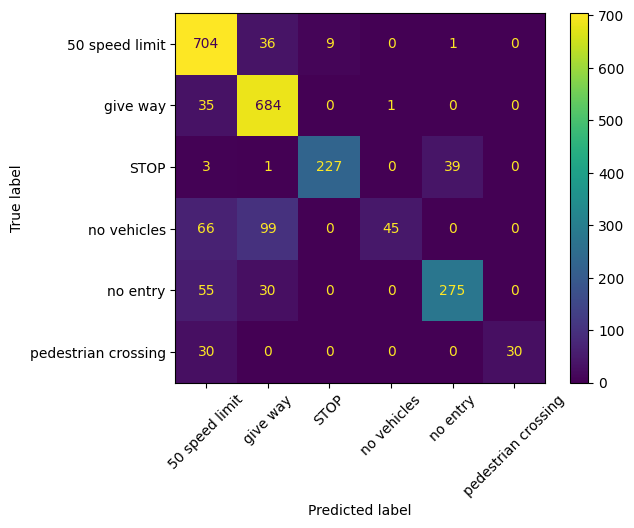

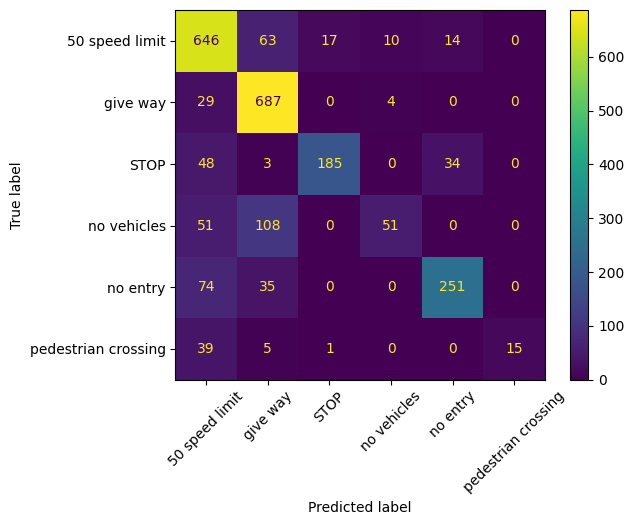

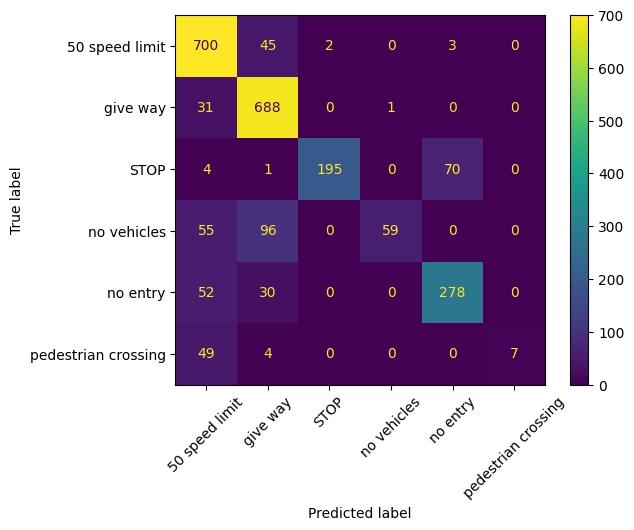

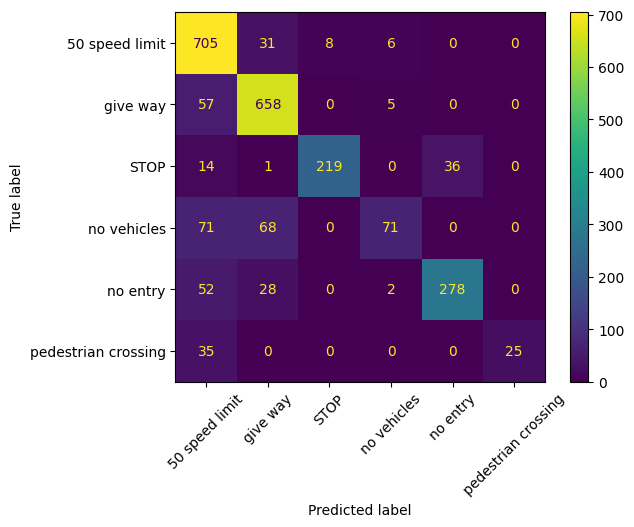

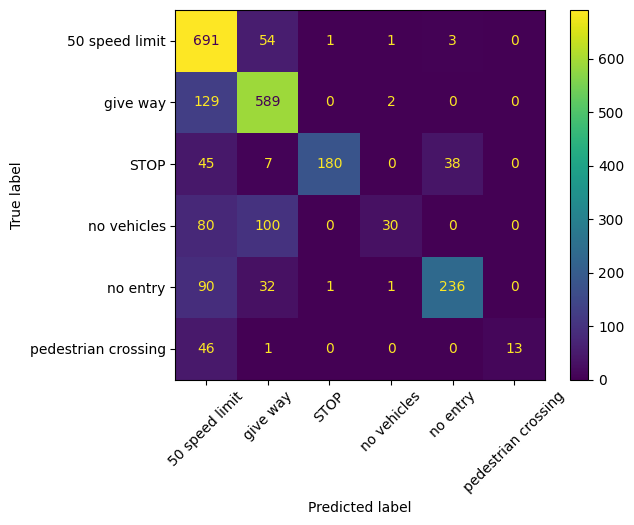

In [ ]:
for name, loader in loaders.items():
    evaluate_with_confusion_matrix(loader, name, classes_map)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving moje_zdj8.png to moje_zdj8.png


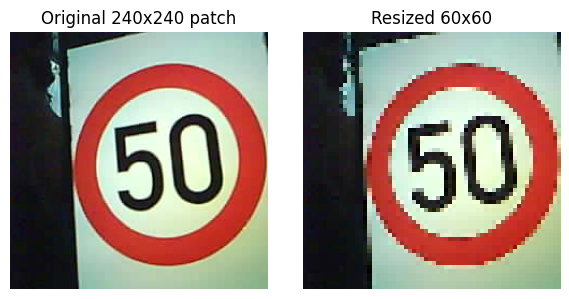

In [ ]:
img = Image.open("moje_zdj8.png")

patch = img.crop((0, 0, 240, 240))

resized = patch.resize((64, 64), resample=Image.NEAREST)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Original 240x240 patch")
plt.imshow(patch)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Resized 60x60")
plt.imshow(resized)
plt.axis("off")

plt.tight_layout()
plt.show()



Prediction for top-left 240x240 patch -> resized 64x64:

50 speed limit        : 2.73%
give way              : 89.98%
STOP                  : 0.19%
no vehicles           : 3.56%
no entry              : 0.01%
pedestrian crossing   : 3.52%


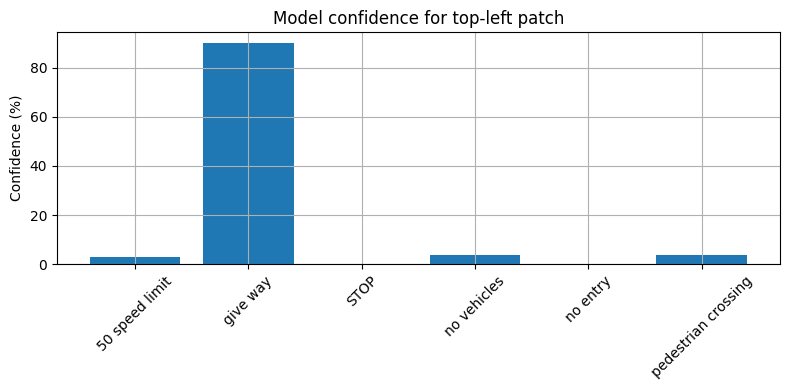

In [ ]:
def predict_patched_image(image_path):
    full_image = Image.open(image_path).convert("RGB")

    patch = full_image.crop((0, 0, 240, 240))

    resized = patch.resize((64, 64), Image.NEAREST)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3)
    ])

    input_tensor = transform(resized).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1).squeeze().cpu().numpy()

    print(f"\nPrediction for top-left 240x240 patch -> resized 64x64:\n")
    for cls, prob in zip(classes_map, probs):
        print(f"{cls:22s}: {prob * 100:.2f}%")

    plt.figure(figsize=(8, 4))
    plt.bar(classes_map, probs * 100)
    plt.ylabel("Confidence (%)")
    plt.xticks(rotation=45)
    plt.title("Model confidence for top-left patch")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

predict_patched_image("moje_zdj7.png")


In [ ]:
dummy_input = torch.randn(1, 3, 64, 64)
torch.onnx.export(
    model,
    dummy_input,
    "sign_model.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes=None,
    opset_version=11
)

In [ ]:
onnx_model = onnx.load("sign_model.onnx")
tf_rep = prepare(onnx_model)
tf_rep.export_graph("sign_model_tf")

INFO:absl:Function `__call__` contains input name(s) x with unsupported characters which will be renamed to transpose_13_x in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.
INFO:absl:Writing fingerprint to sign_model_tf/fingerprint.pb


In [ ]:
image_paths = glob.glob("data/train/**/*.ppm", recursive=True)

In [ ]:
def representative_data_gen():
    for path in image_paths[:100]:
        img = Image.open(path).convert("RGB").resize((64, 64))
        arr = np.array(img).astype(np.float32) / 255.0
        arr = (arr - 0.5) / 0.5
        arr = np.expand_dims(arr, axis=0)       # (1, 64, 64, 3)
        arr = np.transpose(arr, (0, 3, 1, 2))   # (1, 3, 64, 64)
        yield [arr]

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("sign_model_tf")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model = converter.convert()

with open("sign_model.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
from google.colab import files
files.download("sign_model.tflite")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
converter_float = tf.lite.TFLiteConverter.from_saved_model("sign_model_tf")
tflite_model_float = converter_float.convert()

with open("sign_model_float32.tflite", "wb") as f:
    f.write(tflite_model_float)

In [ ]:
from google.colab import files
files.download("sign_model_float32.tflite")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>